# GNSS Radio Occultation Observations

Global Navigation Satellite System (GNSS) Radio Occultation (RO) samples the environment by observing changes to GNSS signals as the pass through the Earth's atmosphere. This TAT-C analysis function models when and where GNSS-RO observations can be sampled at the tangent point between a receiver and transmitter, i.e., point along the line-of-sight with minimum distance to the geocenter. This analysis *does not* consider atmospheric refraction, therefore represents only a coarse estimate of GNSS-RO observations suitable for early-stage mission analysis.

## Mathematical Basis

### Transmitter/Receiver Geometry

Assume the transmitter (tx) and receiver (rx) have positions $x_{tx}$ and $x_{rx}$ and velocities $v_{tx}$ and $v_{rx}$, respectively, in a geocentric inertial frame. The transmitter has position $x_{rx,tx}=x_{tx}-x_{rx}$ and velocity $v_{rx,tx}=v_{tx}-v_{rx}$ relative to the receiver.

<img src="../_static/CollectRO/ro1.png" width=300>

The tangent point has position (via vector geometry):

$x_{tp} = x_{tx} - \left(x_{tx} \cdot \frac{x_{rx,tx}}{||x_{rx,tx}||}\right) x_{rx,tx}$ 

and velocity (via the chain rule):

$v_{tp} = \frac{d x_{tp}}{dt}  = v_{tx} - \left(x_{tx} \cdot \frac{x_{rx,tx}}{||x_{rx,tx}||}\right) v_{rx,tx} - \left[ \frac{v_{tx} \cdot x_{rx,tx} + x_{tx} + v_{rx,tx}}{||x_{rx,tx}||} - 2\frac{\left(x_{tx}\cdot x_{rx,tx}\right)\left(v_{rx,tx}\cdot x_{rx,tx}\right)}{||x_{rx,tx}||^2} \right] x_{rx,tx}$

The pitch angle of the transmitter as viewed by the receiver (above/below local horizon) is given by

$\theta_{rx,tx} = \text{atan2} \left( \tilde{x}_{tx,rx}^n \cdot \frac{x_{rx}}{||x_{rx}||}, \tilde{x}_{tx,rx}^n \cdot \frac{v_{rx}}{||v_{rx}||} \right)$

where

$\tilde{x}_{tx,rx}^n = x_{tx,rx} - (n_{rx} \cdot x_{tx,rx}) n_{rx}$ 

is the relative transmitter position in the plane normal to the receiver orbit, and 

$n_{rx} = \frac{ x_{rx} \times v_{rx}}{||x_{rx} \times v_{rx}||}$ 

is the unit normal to the receiver orbit plane.

<img src="../_static/CollectRO/ro3.png" width=300>

The yaw angle of the transmitter as viewed by the receiver (left/right along local horizontal) is given by

$\Omega_{rx,tx} = \text{atan2} \left( \tilde{x}_{tx,rx}^t \cdot n_{rx}, \tilde{x}_{tx,rx}^t \cdot \frac{v_{rx}}{||v_{rx}||} \right)$

where

$\tilde{x}_{tx,rx}^t = x_{tx,rx} - (\frac{ x_{rx} }{||x_{rx} ||} \cdot x_{tx,rx}) \frac{ x_{rx} }{||x_{rx} ||}$ 

is the relative transmitter position in the plane tangent to the receiver orbit.

<img src="../_static/CollectRO/ro4.png" width=300>

### RO Observation Criteria

There are three criteria for a valid RO observation.

First, the tangent point must be between the transmitter and receiver:

$\text{sgn} \left( (x_{tp} - x_{tx}) \cdot (x_{tp} - x_{rx}) \right) < 0$

<img src="../_static/CollectRO/ro2.png" width=300>

Second, the absolute value yaw angle of the transmitter as viewed by the receiver must be within a maximum bound due to antenna gain patterns:

$\text{mod}\left( | \Omega_{rx,tx}|, 180 - \Omega_{max} \right) < \Omega_{max}$

Third, the height of the tangent point must be within a specified range:

$h_{min} < h < h_{max}$

where $h$ is elevation of the tangent point $x_{tp}$ above a specified geoid such as WGS 84.

## Analysis

First, we define scenario configurations. Three parameters set valid GNSS-RO observation conditions between a receiver and transmitter:
 * `max_yaw` sets the maximum yaw angle (in degrees) between the receiver and transmitter within the receiver's orbit plane.
 * `range_elevation` sets the minimum and maximum allowable elevation (in meters) of the tangent point between receiver and transmitter. While realistic GNSS-RO observations sample the atmosphere, a negative minimum value accounts for the lack of refraction considered in this analysis.
 * `sample_elevation` sets the elevation (in meters) of the tangent point to represent a GNSS-RO observation as a single point, rather than an arc through space.

Other scenario parameters configure the temporal bounds of analysis (`start` and `duration`) and set the temporal resolution of orbital motion (`time_step`).

In [7]:
from datetime import datetime, timedelta, timezone
import numpy as np

# occultation validity constraints
max_yaw = 65  # deg
range_elevation = (-200e3, 60e3)  # m
sample_elevation = 0  # m

# scenario configuration
start = datetime(2023, 12, 9, tzinfo=timezone.utc)
time_step = timedelta(seconds=10)
duration = timedelta(hours=1)
times = np.array([start + i * time_step for i in range(duration // time_step)])

Each analysis relies on the definition of a GNSS receiver (e.g., COSMIC-2 FMS) and one or more GNSS transmitters (e.g., the GPS, GLONASS, Galileo, and BeiDou constellations). The code below imports two line elements (TLEs) for each satellite orbit (as of late 2023) and builds a TAT-C `Satellite` object.

In [8]:
from tatc.schemas import Satellite, TwoLineElements

txs = []

for gnss_dat in ["gps_tle.dat", "glo_tle.dat", "gal_tle.dat", "bei_tle.dat"]:
    with open(gnss_dat, "r") as f:
        lines = f.read().splitlines()
        for i in range(0, len(lines), 3):
            txs.append(
                Satellite(
                    name=lines[i], orbit=TwoLineElements(tle=lines[i + 1 : i + 3])
                )
            )

rx = Satellite(
    name="COSMIC-2 FM5",
    orbit=TwoLineElements(
        tle=[
            "1 44358U 19036V   23354.40324524  .00015027  00000-0  91237-3 0  9994",
            "2 44358  24.0023   0.0734 0003537 251.0816 108.9304 15.08623759245240",
        ]
    ),
)

TAT-C simulates GNSS-RO observations using the `collect_ro_observations` script. The function propagates the position of the receiver and transmitters and computes the three conditions required for a valid GNSS-RO observation: 1) the tangent point must between the receiver and transmitter, 2) the acute receiver-transmitter azimuth angle must be less than `max_azimuth`, and 3) the tangent point elevation must be within the `range_elevation` range.

The outputs report each RO observation including the following fields:
 * `receiver`: the receiver satellite name
 * `transmitter`: the transmitter satellite name
 * `is_rising`: true, if the receiver-transmitter azimuth angle is less than `max_azimuth` (false indicates it is greater than 180 - `max_azimuth`)
 * `geometry`: a multipoint geometry that describes the observation arc of points separated by `time_step`
 * `position`: a point geometry that describes the observation closest to the `sample_elevation` value
 * `rx_tx_azimuth`: the transmitter azimuth angle as viewed by the receiver
 * `tp_tx_azimuth`: the transmitter azimuth angle as viewed by the tangent point (i.e., degrees clockwise from North)
 * `start`: start of the RO observation arc
 * `end`: end of the RO observation arc
 * `time`: time of the observation closest to the `sample_elevation` value


In [9]:
from tatc.analysis import collect_ro_observations

ro_obs = collect_ro_observations(
    rx, txs, times, sample_elevation, max_yaw, range_elevation
)
display(ro_obs)

receiver               transmitter  is_rising  \
0    COSMIC-2 FM5  BEIDOU-3 M7 (C27)             False   
1    COSMIC-2 FM5  COSMOS 2534 (758)             False   
2    COSMIC-2 FM5  BEIDOU-3 M12 (C26)             True   
3    COSMIC-2 FM5  COSMOS 2557 (706K)            False   
4    COSMIC-2 FM5  GSAT0215 (PRN E21)             True   
..            ...                       ...        ...   
133  COSMIC-2 FM5  BEIDOU-3S M1S (C58)           False   
134  COSMIC-2 FM5  BEIDOU-3 M12 (C26)            False   
135  COSMIC-2 FM5  COSMOS 2500 (755)              True   
136  COSMIC-2 FM5  GSAT0224 (PRN E10)             True   
137  COSMIC-2 FM5  GPS BIIF-8  (PRN 03)           True   

                                              geometry  \
0    MULTIPOINT Z (-0.03172 8.43027 -111422.03599, ...   
1    MULTIPOINT Z (8.38669 15.17354 -20482.00391, 8...   
2    MULTIPOINT Z (43.67416 -10.25178 12330.4085, 4...   
3    MULTIPOINT Z (5.13858 7.72295 58877.01276, 5.2...   
4    MULTIPOINT Z (43.4354 -21.61952 -197994.75109,...   
..                                                 ...   
133  MULTIPOINT Z (-148.06901 -0.43361 47281.53233,...   
134  MULTIPOINT Z (-157.82214 20.0755 44731.25716, ...   
135  MULTIPOINT Z (-126.69412 44.90944 -194723.7506...   
136  MULTIPOINT Z (-123.55537 45.42334 -193679.7174...   
137  MULTIPOINT Z (-102.06523 18.52248 -194739.9090...   

                                              position  rx_tx_pitch  \
0    POINT Z (-0.0317183312985065 8.430274910021483...  -154.829254   
1    POINT Z (8.386687522755755 15.173539678375606 ...  -153.251127   
2    POINT Z (43.67415791885335 -10.251779478855163...   -22.664009   
3    POINT Z (5.509687281172558 7.9175282357802645 ...  -156.574267   
4    POINT Z (44.94849495030172 -20.81904846996197 ...   -23.893350   
..                                                 ...          ...   
133  POINT Z (-146.992685046998 -0.8190136846429314...  -151.471053   
134  POINT Z (-157.66151831979104 20.63188433047461...  -155.288807   
135  POINT Z (-121.58919915764217 44.59651929331758...   -47.093233   
136  POINT Z (-121.36527296079892 45.17437814841084...   -47.875649   
137  POINT Z (-101.93398093154444 18.83019958019392...   -25.946455   

      rx_tx_yaw  tp_tx_azimuth                     start  \
0    174.181601     298.666783 2023-12-09 00:00:00+00:00   
1    148.414002     323.957256 2023-12-09 00:00:00+00:00   
2      6.514396     104.465665 2023-12-09 00:00:00+00:00   
3    169.009785     304.029604 2023-12-09 00:00:20+00:00   
4    -17.767677     126.837457 2023-12-09 00:00:10+00:00   
..          ...            ...                       ...   
133 -140.421688     212.568932 2023-12-09 00:57:50+00:00   
134  154.959046     271.270420 2023-12-09 00:58:10+00:00   
135   63.730350      16.239802 2023-12-09 00:58:40+00:00   
136   63.751499      16.226191 2023-12-09 00:59:20+00:00   
137  -11.634382      96.639069 2023-12-09 00:59:30+00:00   

                          end                      time  
0   2023-12-09 00:00:30+00:00 2023-12-09 00:00:00+00:00  
1   2023-12-09 00:01:20+00:00 2023-12-09 00:00:00+00:00  
2   2023-12-09 00:00:20+00:00 2023-12-09 00:00:00+00:00  
3   2023-12-09 00:02:00+00:00 2023-12-09 00:00:50+00:00  
4   2023-12-09 00:01:50+00:00 2023-12-09 00:01:30+00:00  
..                        ...                       ...  
133 2023-12-09 00:59:50+00:00 2023-12-09 00:58:20+00:00  
134 2023-12-09 00:59:50+00:00 2023-12-09 00:58:30+00:00  
135 2023-12-09 00:59:50+00:00 2023-12-09 00:59:50+00:00  
136 2023-12-09 00:59:50+00:00 2023-12-09 00:59:50+00:00  
137 2023-12-09 00:59:50+00:00 2023-12-09 00:59:50+00:00  

[138 rows x 11 columns]

The RO observations can be better visualized by combining with the receiver orbit track.

In [10]:
from tatc.analysis import collect_orbit_track

orbit_track = collect_orbit_track(rx, times)

The resulting plot shows the receiver orbit track and RO observations categorized as rising or setting.

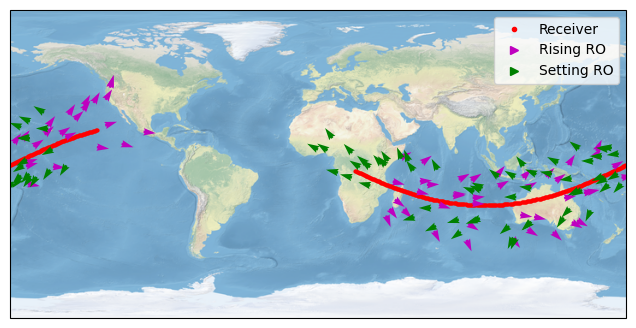

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={"projection": ccrs.PlateCarree()})
orbit_track.plot(ax=ax, marker=".", color="r", lw=0, transform=ccrs.PlateCarree())
ax.quiver(
    ro_obs.apply(lambda r: r.position.x, axis=1),
    ro_obs.apply(lambda r: r.position.y, axis=1),
    ro_obs.apply(lambda r: np.sin(np.radians(r.tp_tx_azimuth)), axis=1),
    ro_obs.apply(lambda r: np.cos(np.radians(r.tp_tx_azimuth)), axis=1),
    color=ro_obs.apply(lambda r: "m" if r.is_rising else "g", axis=1),
    scale=50,
    scale_units="width",
    transform=ccrs.PlateCarree()
)
ax.stock_img()
ax.set_global()
ax.legend(
    handles=[
        Line2D([0], [0], marker=".", color="r", lw=0, label="Receiver"),
        Line2D([0], [0], marker=">", color="m", lw=0, label="Rising RO"),
        Line2D([0], [0], marker=">", color="g", lw=0, label="Setting RO"),
    ]
)
plt.show()

An animation can show the dynamic collection of RO observations aggregated to individual frames.

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from IPython.display import HTML
from datetime import timedelta

fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree()})

frame_duration = timedelta(minutes=1)
num_frames = int(duration / frame_duration)


def animate(frame):
    ax.clear()
    time = times[0] + frame * frame_duration
    ax.plot(

    )
    orbit_track.loc[
        (orbit_track.time >= time) & (orbit_track.time < time + frame_duration)
    ].plot(ax=ax, marker=".", color="r", lw=0, transform=ccrs.PlateCarree())
    ro_obs_filtered = ro_obs.loc[
        (ro_obs.start >= time) & (ro_obs.start < time + frame_duration)
    ]
    if not ro_obs_filtered.empty:
        ro_obs_filtered.apply(
            lambda r: ax.plot(
                [point.x for point in r.geometry.geoms],
                [point.y for point in r.geometry.geoms],
                ".m" if r.is_rising else ".g",
                markersize=1,
                transform=ccrs.PlateCarree()
            ),
            axis=1,
        )
        ax.quiver(
            ro_obs_filtered.apply(lambda r: r.position.x, axis=1),
            ro_obs_filtered.apply(lambda r: r.position.y, axis=1),
            ro_obs_filtered.apply(
                lambda r: np.sin(np.radians(r.tp_tx_azimuth)), axis=1
            ),
            ro_obs_filtered.apply(
                lambda r: np.cos(np.radians(r.tp_tx_azimuth)), axis=1
            ),
            color=ro_obs_filtered.apply(lambda r: "m" if r.is_rising else "g", axis=1),
            scale=50,
            scale_units="width",
            transform=ccrs.PlateCarree()
        )
    ax.set_global()
    ax.coastlines()
    ax.set_aspect("equal")
    ax.legend(
        handles=[
            Line2D([0], [0], marker=".", color="r", lw=0, label="Receiver"),
            Line2D([0], [0], marker=">", color="m", lw=0, label="Rising RO"),
            Line2D([0], [0], marker=">", color="g", lw=0, label="Setting RO"),
        ]
    )
    ax.set_title(
        time.strftime("%x %X") + "$-$" + (time + frame_duration).strftime("%X")
    )
    fig.tight_layout()


ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=200, blit=False)
display(HTML(ani.to_jshtml()))
plt.close()